In [13]:
# https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [14]:
!pip install -U scikit-image

Requirement already up-to-date: scikit-image in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.18.1)


In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [16]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [17]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

[-0.10574759 -0.10142771 -0.10100362 ...  0.18634044  0.18917355
  0.18917514]
(300, 300, 1)
float32


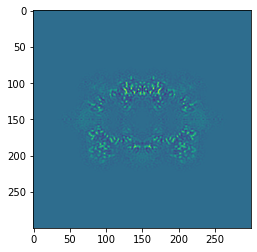

"\n# test_numpy = np.array(test_map.grid, copy=False)\ntest_numpy = (test_numpy - np.amin(test_numpy)) / (np.amax(test_numpy) - np.amin(test_numpy))\ntest_slice = test_numpy[:, :, test_numpy.shape[2] // 2]\ntest_slice = np.expand_dims(test_slice, axis=-1)\n\nplt.imshow(test_slice, cmap='gray', vmin=0, vmax=1)\n\nc = [test_slice.shape[0]//2, test_slice.shape[1]//2]\nr = 256 // 2\nimg = test_slice[c[0]-r:c[0]+r, c[1]-r:c[1]+r]\n"

In [18]:
# Getting test T20S map
if not (os.path.exists('emd_6287.map.gz') or os.path.exists('emd_6287.map')):
    !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    !gunzip 'emd_6287.map.gz'
map_path = 'emd_6287.map'

# https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
test_map = gemmi.read_ccp4_map(map_path)
test_map.setup()  # optional


test_numpy = np.array(test_map.grid, copy=False)
# test_slice = test_numpy[test_numpy.shape[2] // 2, :, :]
test_slice = test_numpy[:, test_numpy.shape[2] // 2, :]
img = np.expand_dims(test_slice, axis=-1)

print(np.unique(img))
print(img.shape)
print(img.dtype)

plt.imshow(img)
plt.show()

'''
# test_numpy = np.array(test_map.grid, copy=False)
test_numpy = (test_numpy - np.amin(test_numpy)) / (np.amax(test_numpy) - np.amin(test_numpy))
test_slice = test_numpy[:, :, test_numpy.shape[2] // 2]
test_slice = np.expand_dims(test_slice, axis=-1)

plt.imshow(test_slice, cmap='gray', vmin=0, vmax=1)

c = [test_slice.shape[0]//2, test_slice.shape[1]//2]
r = 256 // 2
img = test_slice[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
'''

In [19]:
output_dims = 300

In [20]:
def convert_to_tensor(img, sidelength):
    transform = Compose([
        ToPILImage(),
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = convert_to_tensor(img, sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

particle_slice = ImageFitting(img, output_dims)
dataloader = DataLoader(particle_slice, batch_size=1, pin_memory=True, num_workers=0)

siren_model = Siren(in_features=2, out_features=1, hidden_features=128, 
                  hidden_layers=3, outermost_linear=True)
siren_model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [21]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
model_output, coords = siren_model(model_input)
model_output = model_output.cpu().view(output_dims, output_dims).detach().numpy()

In [22]:
total_steps = 2500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=siren_model.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = siren_model(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        '''
        fig, axes = plt.subplots(1,1, figsize=(18,6))
        axes.imshow(model_output.cpu().view(output_dims,output_dims).detach().numpy())
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()
        '''

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.936579
Step 10, Total loss 0.284152
Step 20, Total loss 0.158784
Step 30, Total loss 0.070590
Step 40, Total loss 0.025309
Step 50, Total loss 0.006630
Step 60, Total loss 0.001365
Step 70, Total loss 0.000663
Step 80, Total loss 0.000743
Step 90, Total loss 0.000676
Step 100, Total loss 0.000669
Step 110, Total loss 0.000656
Step 120, Total loss 0.000648
Step 130, Total loss 0.000645
Step 140, Total loss 0.000643
Step 150, Total loss 0.000640
Step 160, Total loss 0.000638
Step 170, Total loss 0.000636
Step 180, Total loss 0.000634
Step 190, Total loss 0.000632
Step 200, Total loss 0.000631
Step 210, Total loss 0.000629
Step 220, Total loss 0.000628
Step 230, Total loss 0.000627
Step 240, Total loss 0.000626
Step 250, Total loss 0.000625
Step 260, Total loss 0.000624
Step 270, Total loss 0.000623
Step 280, Total loss 0.000622
Step 290, Total loss 0.000621
Step 300, Total loss 0.000620
Step 310, Total loss 0.000619
Step 320, Total loss 0.000619
Step 330, Total loss 

Step 2690, Total loss 0.000474
Step 2700, Total loss 0.000473
Step 2710, Total loss 0.000472
Step 2720, Total loss 0.000470
Step 2730, Total loss 0.000469
Step 2740, Total loss 0.000468
Step 2750, Total loss 0.000466
Step 2760, Total loss 0.000465
Step 2770, Total loss 0.000464
Step 2780, Total loss 0.000463
Step 2790, Total loss 0.000461
Step 2800, Total loss 0.000460
Step 2810, Total loss 0.000459
Step 2820, Total loss 0.000457
Step 2830, Total loss 0.000456
Step 2840, Total loss 0.000454
Step 2850, Total loss 0.000453
Step 2860, Total loss 0.000452
Step 2870, Total loss 0.000450
Step 2880, Total loss 0.000449
Step 2890, Total loss 0.000447
Step 2900, Total loss 0.000446
Step 2910, Total loss 0.000445
Step 2920, Total loss 0.000443
Step 2930, Total loss 0.000442
Step 2940, Total loss 0.000440
Step 2950, Total loss 0.000439
Step 2960, Total loss 0.000437
Step 2970, Total loss 0.000436
Step 2980, Total loss 0.000434
Step 2990, Total loss 0.000433
Step 3000, Total loss 0.000431
Step 301

In [23]:
final_siren_output = model_output.cpu().view(output_dims, output_dims).detach().numpy()
# final_siren_output_grad = img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy()
# final_siren_output_laplacian = img_laplacian.cpu().view(256,256).detach().numpy()

(300, 300)
(300, 300)
[-0.10574759 -0.10142771 -0.10100362 ...  0.18634044  0.18917355
  0.18917514]
[-1.1972885  -1.1787333  -1.1632943  ... -0.65164655 -0.6485115
 -0.64345807]


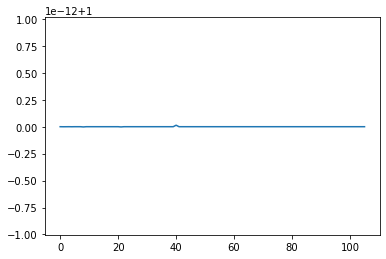

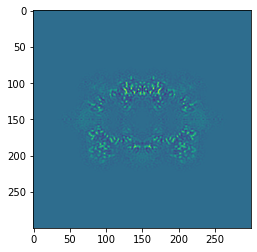

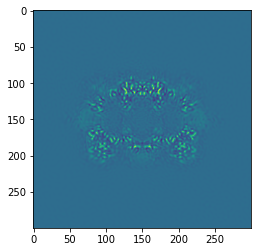

In [24]:
# Fourier ring coefficient test
    # https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html
    


def compute_frc(
        image_1: np.ndarray,
        image_2: np.ndarray,
        bin_width: int = 2.0
):
    """ Computes the Fourier Ring/Shell Correlation of two 2-D images

    :param image_1:
    :param image_2:
    :param bin_width:
    :return:
    """
    image_1 = image_1 / np.sum(image_1)
    image_2 = image_2 / np.sum(image_2)
    f1, f2 = np.fft.fft2(image_1), np.fft.fft2(image_2)
    af1f2 = np.real(f1 * np.conj(f2))
    af1_2, af2_2 = np.abs(f1)**2, np.abs(f2)**2
    nx, ny = af1f2.shape
    x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
    y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
    distances = list()
    wf1f2 = list()
    wf1 = list()
    wf2 = list()
    for xi, yi in np.array(np.meshgrid(x,y)).T.reshape(-1, 2):
        distances.append(np.sqrt(xi**2 + xi**2))
        xi = int(xi)
        yi = int(yi)
        wf1f2.append(af1f2[xi, yi])
        wf1.append(af1_2[xi, yi])
        wf2.append(af2_2[xi, yi])

    bins = np.arange(0, np.sqrt((nx//2)**2 + (ny//2)**2), bin_width)
    f1f2_r, bin_edges = np.histogram(
        distances,
        bins=bins,
        weights=wf1f2
    )
    f12_r, bin_edges = np.histogram(
        distances,
        bins=bins,
        weights=wf1
    )
    f22_r, bin_edges = np.histogram(
        distances,
        bins=bins,
        weights=wf2
    )
    density = f1f2_r / np.sqrt(f12_r * f22_r)
    return density, bin_edges

# original_image = (img.squeeze() - np.amin(img)) / (np.amax(img) - np.amin(img))
# pred_image = (final_siren_output - np.amin(final_siren_output)) / (np.amax(final_siren_output) - np.amin(final_siren_output))
original_image = img.squeeze()
pred_image = final_siren_output

print(original_image.shape)
print(pred_image.shape)
print(np.unique(original_image))
print(np.unique(pred_image))

frc, frc_bins = compute_frc(original_image, original_image)
plt.plot(frc, label="Intensity")
plt.show()

plt.imshow(original_image)
plt.show()
plt.imshow(pred_image)
plt.show()